##LeNet architecture
conv 3x3 + relu \\
maxPolling 2x2 \\
conv 3x3 + relu \\
maxPolling 2x2 \\
Flatten \\
fully connected + relu \\
fully connected + relu \\
fully connected 

In [10]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])


"""
download test and train datasets
transform for example to avoid overfitting: we can "mirror" pictures to enlarge dataset, but there we only have to normalize and ToTenzor
"""
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)  
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)


"""
- shuffle=True, because we want all classes to shuffle, otherwise net forgets about what it has learned on the previous classes and
    the result is created only from the last class the net has met during learning
- num_workers for parallel computations
- one iteration of Dataloader has batch_size = 128
"""
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)   
valid_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                          shuffle=False, num_workers=2)

In [17]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # create layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  #5*5*16 is x.shape after two poolings is def forward (*)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # forward through layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x.shape (*)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()   #loss function (because we have classification with many classes)
optimizer = torch.optim.Adam(model.parameters())   #optimizer

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [19]:
max_epochs = 5
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                optimizer.zero_grad()
                output = model(x_batch.to(device))
            else:
                model.eval()   #test mode, disable gradient computation
                output = model(x_batch.to(device))
            preds = output.argmax(-1)   #choose the class which index is the biggest
            all = y_batch.shape[0]
            correct =  (preds == y_batch.to(device)).sum()
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":    #do gradient descent step
                loss = criterion(output, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8814833333333333
Loader: valid. Accuracy: 0.9576
Epoch: 2
Loader: train. Accuracy: 0.9704333333333334
Loader: valid. Accuracy: 0.9765
Epoch: 3
Loader: train. Accuracy: 0.9783666666666667
Loader: valid. Accuracy: 0.9817
Epoch: 4
Loader: train. Accuracy: 0.9830833333333333
Loader: valid. Accuracy: 0.9821
Epoch: 5
Loader: train. Accuracy: 0.9863333333333333
Loader: valid. Accuracy: 0.9866


In [21]:
lenet_accuracy = accuracy["valid"]

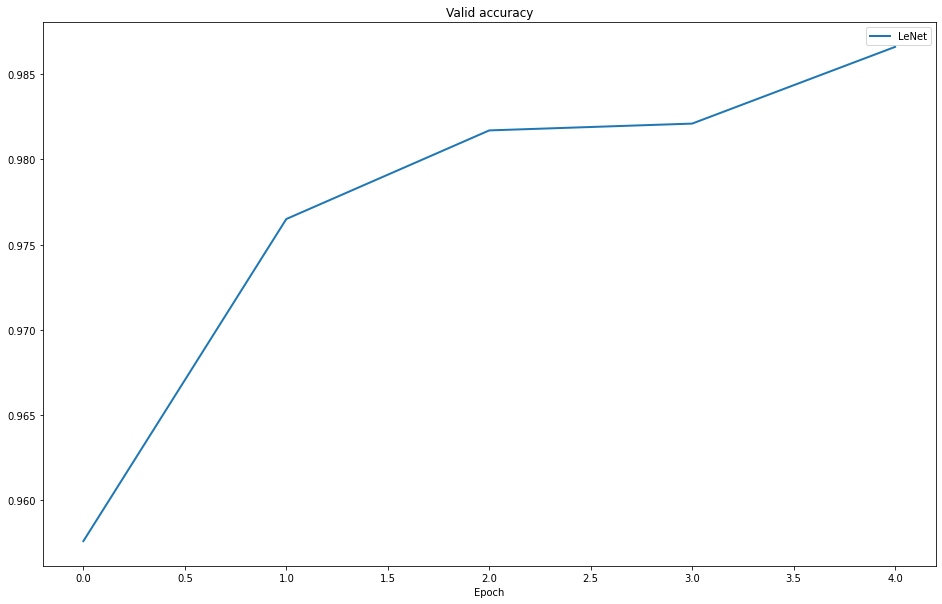

In [22]:
plt.figure(figsize=(16, 10))
plt.title("LeNet accuracy")
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()